**Problem Statement**

As Data Science team of Zee, we are trying to understand and create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience so that Zee can increase user interaction and  and optimize to provide personalized recommendations.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
import re
from scipy import sparse
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import accuracy

In [7]:
data_users=pd.read_csv("zee-users.dat",sep='::', header=None, engine='python')
data_users.to_csv('output_file1.csv', index=False, sep=',', encoding='utf-8')
new_header = data_users.iloc[0]
data_users = data_users[1:]
data_users.columns = new_header
data_users.reset_index(inplace=True)
data_users.drop(columns=['index'],inplace=True)

In [8]:
data_movies=pd.read_csv("zee-movies.dat",sep='::', header=None,encoding='latin1', engine='python')
data_movies.to_csv('output_file2.csv', index=False, sep=',', encoding='utf-8')
new_header = data_movies.iloc[0]
data_movies = data_movies[1:]
data_movies.columns = new_header
data_movies.reset_index(inplace=True)
data_movies.drop(columns=['index'],inplace=True)

In [9]:
data_rating=pd.read_csv("zee-ratings.dat",sep='::', header=None, engine='python')
data_rating.to_csv('output_file.csv', index=False, sep=',', encoding='utf-8')
new_header = data_rating.iloc[0]
data_rating = data_rating[1:]
data_rating.columns = new_header
data_rating.reset_index(inplace=True)
data_rating.drop(columns=['index'],inplace=True)

**EDA**

In [10]:
data_rating.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [11]:
data_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   UserID     1000209 non-null  object
 1   MovieID    1000209 non-null  object
 2   Rating     1000209 non-null  object
 3   Timestamp  1000209 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


In [12]:
data_rating.describe(include='all')

,UserID,MovieID,Rating,Timestamp
count,1000209,1000209,1000209,1000209
unique,6040,3706,5,458455
top,4169,2858,4,975528402
freq,2314,3428,348971,30


In [13]:
data_rating.shape

(1000209, 4)

In [14]:
if data_rating.duplicated().any():
    print("Duplicates exist in the DataFrame.")
else:
    print("No duplicates found in the DataFrame.")

No duplicates found in the DataFrame.


In [15]:
data_rating.isna().sum()

0
UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

<Axes: xlabel='Rating', ylabel='count'>

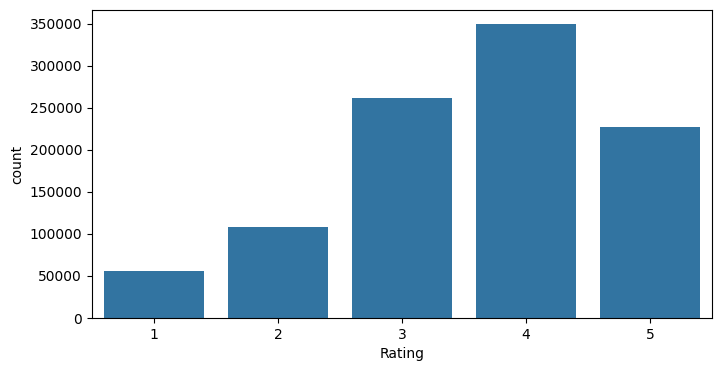

In [16]:
plt.figure(figsize=(8,4))
sns.countplot(data=data_rating,x='Rating',order=[1,2,3,4,5])

In [17]:
print("The total no of ratings given : ",data_rating.shape[0])
print("The total number of unique users are : ",data_rating['UserID'].nunique())
print("Frequency of rating per user : ",data_rating.shape[0]/data_rating['UserID'].nunique())

The total no of ratings given :  1000209
The total number of unique users are :  6040
Frequency of rating per user :  165.5975165562914


In [18]:
data_users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [19]:
 data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   object
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   object
 3   Occupation  6040 non-null   object
 4   Zip-code    6040 non-null   object
dtypes: object(5)
memory usage: 236.1+ KB


In [20]:
data_users.replace({'Age':{'1':  "Under 18",
                      '18':  "18-24",
                      '25':  "25-34",
                      '35':  "35-44",
                      '45':  "45-49",
                      '50':  "50-55",
                      '56':  "56 Above"}}, inplace=True)

In [21]:
data_users.replace({'Occupation':{'0': "other",
                             '1': "academic/educator",
                             '2': "artist",
                             '3': "clerical/admin",
                             '4': "college/grad student",
                             '5': "customer service",
                             '6': "doctor/health care",
                             '7': "executive/managerial",
                             '8': "farmer",
                             '9': "homemaker",
                             '10': "k-12 student",
                             '11': "lawyer",
                             '12': "programmer",
                             '13': "retired",
                             '14': "sales/marketing",
                             '15': "scientist",
                             '16': "self-employed",
                             '17': "technician/engineer",
                             '18': "tradesman/craftsman",
                             '19': "unemployed",
                             '20': "writer"}}, inplace=True)

In [22]:
data_users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,Under 18,k-12 student,48067
1,2,M,56 Above,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455


In [23]:
if data_users.duplicated().any():
    print("Duplicates exist in the DataFrame.")
else:
    print("No duplicates found in the DataFrame.")

No duplicates found in the DataFrame.


In [24]:
data_users.describe(include='all')

,UserID,Gender,Age,Occupation,Zip-code
count,6040,6040,6040,6040,6040
unique,6040,2,7,21,3439
top,1,M,25-34,college/grad student,48104
freq,1,4331,2096,759,19


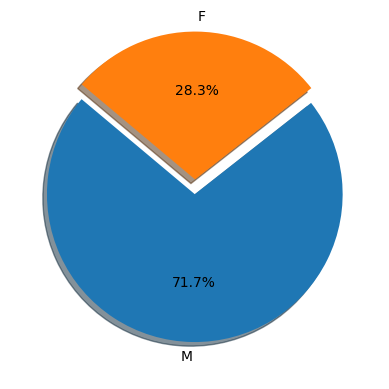

In [25]:
Gender_data=data_users['Gender'].value_counts()
plt.pie(Gender_data, labels=Gender_data.index, autopct='%1.1f%%', startangle=140,explode=(0,0.1),shadow=True)
plt.show()

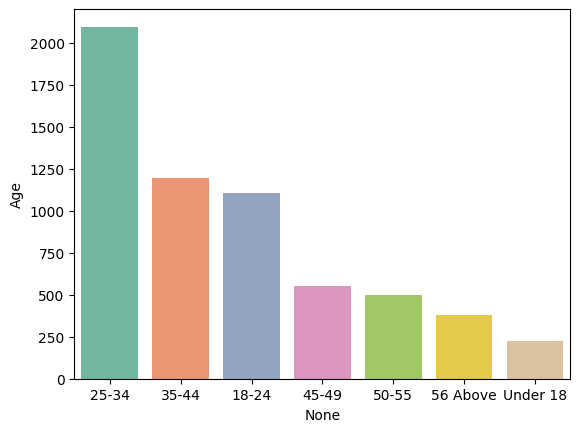

In [26]:
Age_data=data_users['Age'].value_counts()
sns.barplot(y=Age_data, x=Age_data.index,palette='Set2')
plt.show()

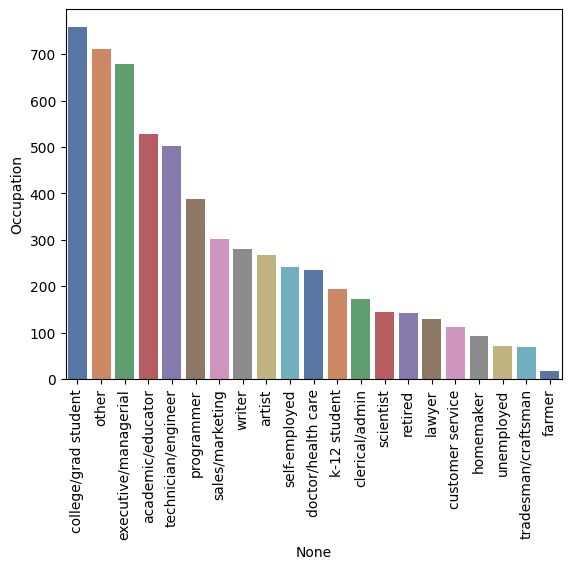

In [27]:
occupation_data=data_users['Occupation'].value_counts()
sns.barplot(y=occupation_data, x=occupation_data.index,palette='deep')
plt.xticks(rotation=90)
plt.show()

In [28]:
data_users.shape

(6040, 5)

In [29]:
data_users.isna().sum()

0
UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64

In [30]:
data_movies.head()

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [31]:
data_movies['Genres'].value_counts().head(10)

Drama             843
Comedy            521
Horror            178
Comedy|Drama      162
Comedy|Romance    142
Drama|Romance     134
Documentary       116
Thriller          101
Action             65
Drama|Thriller     63
Name: Genres, dtype: int64

In [32]:
if data_movies.duplicated().any():
    print("Duplicates exist in the DataFrame.")
else:
    print("No duplicates found in the DataFrame.")

No duplicates found in the DataFrame.


In [33]:
data_movies.rename(columns={'Movie ID':'MovieID'}, inplace=True)

In [34]:
data_movies.describe()

,MovieID,Title,Genres
count,3883,3883,3883
unique,3883,3883,301
top,1,Toy Story (1995),Drama
freq,1,1,843


In [35]:
data_movies.shape

(3883, 3)

In [36]:
data_movies.isna().sum()

0
MovieID    0
Title      0
Genres     0
dtype: int64

In [37]:
data_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   object
 1   Title    3883 non-null   object
 2   Genres   3883 non-null   object
dtypes: object(3)
memory usage: 91.1+ KB


**Initial** **Insights**

In [38]:
## The datset is for dates between 2000-04-25 23:05:32 and 2003-02-28 17:49:50
## On a average , a single users gives 165 ratings.
## most frequent rating given to movie : 4
## Drama and comedy is the biggest genre.
## No missing values in any of the dataset.
## No duplicates present in any of the datframe
## Users datset has majority of male users.
## Users of age 25 and 35 gives mosty of the ratings.
## Students and undergrad tends to give more ratings.
## People of the age group 25-34 tends to give more ratings.

**Data** **Preprocessing**

In [39]:
df1 = pd.merge(data_movies, data_rating, how='inner', on='MovieID')
df1.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474


In [40]:
df2 = pd.merge(df1, data_users, how='inner', on='UserID')
df2.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,Under 18,k-12 student,48067
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,Under 18,k-12 student,48067
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,Under 18,k-12 student,48067
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,Under 18,k-12 student,48067
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,Under 18,k-12 student,48067


In [41]:
data = df2.copy(deep=True)
data.sample(2)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
285372,322,Swimming with Sharks (1995),Comedy|Drama,3067,4,1003864076,F,25-34,other,02148
573178,2676,Instinct (1999),Drama|Thriller,6000,3,956884496,M,45-49,technician/engineer,30075


In [42]:
data.shape

(1000209, 10)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   MovieID     1000209 non-null  object
 1   Title       1000209 non-null  object
 2   Genres      1000209 non-null  object
 3   UserID      1000209 non-null  object
 4   Rating      1000209 non-null  object
 5   Timestamp   1000209 non-null  object
 6   Gender      1000209 non-null  object
 7   Age         1000209 non-null  object
 8   Occupation  1000209 non-null  object
 9   Zip-code    1000209 non-null  object
dtypes: object(10)
memory usage: 83.9+ MB


In [44]:
data['Rating'] = data['Rating'].astype('int32')
data['Datetime'] = pd.to_datetime(data['Timestamp'], unit='s')

In [45]:
data.head(3)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datetime
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,Under 18,k-12 student,48067,2001-01-06 23:37:48
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,Under 18,k-12 student,48067,2001-01-06 23:39:11
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,Under 18,k-12 student,48067,2000-12-31 22:29:37


In [46]:
data["ReleaseYear"] = data["Title"].str.extract(r'\((\d{4})\)$')

In [47]:
data['ReleaseYear'].unique()

array(['1995', '1977', '1993', '1992', '1937', '1991', '1996', '1964',
       '1939', '1958', '1950', '1941', '1965', '1982', '1975', '1987',
       '1962', '1989', '1985', '1959', '1997', '1998', '1988', '1942',
       '1947', '1999', '1980', '1983', '1986', '1990', '2000', '1994',
       '1978', '1961', '1984', '1972', '1976', '1981', '1973', '1974',
       '1940', '1963', '1952', '1954', '1953', '1944', '1968', '1957',
       '1946', '1949', '1951', '1971', '1979', '1967', '1966', '1948',
       '1933', '1970', '1969', '1930', '1955', '1956', '1934', '1920',
       '1925', '1938', '1960', '1935', '1932', '1931', '1945', '1943',
       '1936', '1929', '1926', '1927', '1922', '1919', '1921', '1923',
       '1928'], dtype=object)

In [48]:
data['ReleaseYear'] = data['ReleaseYear'].astype('int32')

In [49]:
data['Title'] = data['Title'].apply(lambda x: str(x).rsplit(" ",1)[0])

In [50]:
bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000]
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
data['ReleaseDecade'] = pd.cut(data['ReleaseYear'], bins=bins, labels=labels)

In [51]:
data.head(3)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datetime,ReleaseYear,ReleaseDecade
0,1,Toy Story,Animation|Children's|Comedy,1,5,978824268,F,Under 18,k-12 student,48067,2001-01-06 23:37:48,1995,90s
1,48,Pocahontas,Animation|Children's|Musical|Romance,1,5,978824351,F,Under 18,k-12 student,48067,2001-01-06 23:39:11,1995,90s
2,150,Apollo 13,Drama,1,5,978301777,F,Under 18,k-12 student,48067,2000-12-31 22:29:37,1995,90s


In [52]:
data.sample(5)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datetime,ReleaseYear,ReleaseDecade
891322,2322,Soldier,Action|Adventure|Sci-Fi|Thriller|War,2852,4,972507604,M,25-34,programmer,98037,2000-10-25 21:00:04,1998,90s
131481,3178,"Hurricane, The",Drama,1347,4,974772754,F,18-24,academic/educator,11375,2000-11-21 02:12:34,1999,90s
306331,3256,Patriot Games,Action|Thriller,3311,2,967955021,M,25-34,college/grad student,90039,2000-09-03 04:23:41,1992,90s
165757,1975,Friday the 13th Part 2,Horror,1680,3,974709466,M,25-34,writer,95380,2000-11-20 08:37:46,1981,80s
195640,3614,Honeymoon in Vegas,Comedy|Romance,1941,2,974950227,M,35-44,technician/engineer,94550,2000-11-23 03:30:27,1992,90s


In [53]:
data.isna().sum()

0
MovieID           0
Title             0
Genres            0
UserID            0
Rating            0
Timestamp         0
Gender            0
Age               0
Occupation        0
Zip-code          0
Datetime          0
ReleaseYear       0
ReleaseDecade    45
dtype: int64

In [54]:
data.shape

(1000209, 13)

In [55]:
duplicate_rows = data[data.duplicated()]
print("No. of duplicate rows: ", duplicate_rows.shape[0])

No. of duplicate rows:  0


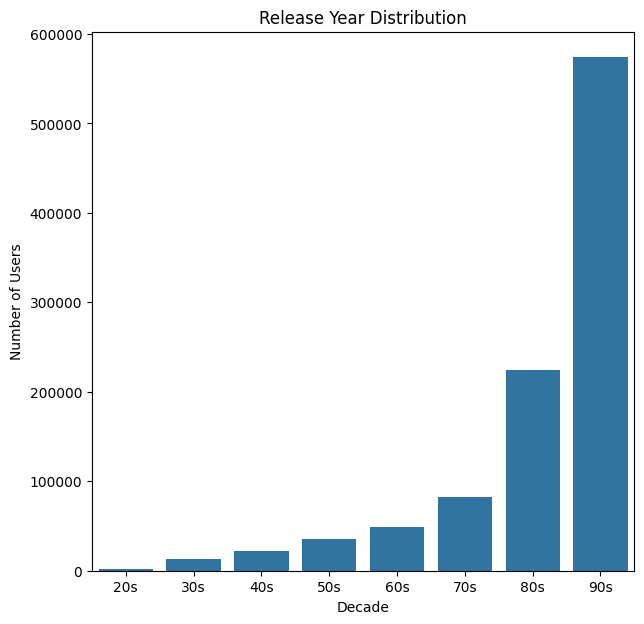

In [56]:
plt.figure(figsize=(7, 7))
sns.countplot(x='ReleaseDecade', data=data)
plt.title('Release Year Distribution')
plt.xlabel('Decade')
plt.ylabel('Number of Users')
plt.show()

In [57]:
## As the time progresses, more and more movies releases. So 90s has most number of movies  in our dataset.

In [58]:
## Average ratings
data.groupby('Title')['Rating'].mean().sort_values(ascending=False).head(10)

Title
Smashing Time                         5.0
Song of Freedom                       5.0
One Little Indian                     5.0
Ulysses (Ulisse)                      5.0
Baby, The                             5.0
Follow the Bitch                      5.0
Schlafes Bruder (Brother of Sleep)    5.0
Gate of Heavenly Peace, The           5.0
Bittersweet Motel                     5.0
Lured                                 5.0
Name: Rating, dtype: float64

In [59]:
## No of ratings
data.groupby('Title')['Rating'].count().sort_values(ascending=False).head(10)

Title
American Beauty                                   3428
Star Wars: Episode IV - A New Hope                2991
Star Wars: Episode V - The Empire Strikes Back    2990
Star Wars: Episode VI - Return of the Jedi        2883
Jurassic Park                                     2672
Saving Private Ryan                               2653
Terminator 2: Judgment Day                        2649
Matrix, The                                       2590
Back to the Future                                2583
Silence of the Lambs, The                         2578
Name: Rating, dtype: int64

In [60]:
df = pd.DataFrame(data.groupby('Title')['Rating'].agg([('Avg rating', 'mean')]))
df['No. of ratings'] = pd.DataFrame(data.groupby('Title')['Rating'].count())

In [61]:
df.sample(5)

,Avg rating,No. of ratings
Title,,
Gods and Monsters,3.813149,578
JLG/JLG - autoportrait de décembre,3.500000,4
Blue Velvet,3.762997,654
Rounders,3.608696,345
Beverly Hills Ninja,2.547414,232


In [62]:
data_movies['Title'].unique()

array(['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
       ..., 'Tigerland (2000)', 'Two Family House (2000)',
       'Contender, The (2000)'], dtype=object)

**Pivot**

In [63]:
piv = pd.pivot_table(data, index='UserID', columns='Title', values='Rating', aggfunc='mean')
piv.head(10)

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
piv.fillna(0, inplace=True)

In [65]:
piv.head(3)

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
print(piv.shape)

(6040, 3664)


**Model**

**Pearson** **Coefficient**

In [67]:
movie_name = input("Enter a movie name: ")
movie_rating = piv[movie_name]

Enter a movie name: Jumanji


In [68]:
recom_movies = piv.corrwith(movie_rating)

In [69]:
rec_df = pd.DataFrame(recom_movies, columns=['Correlation'])
rec_df.sort_values('Correlation', ascending=False, inplace=True)

In [70]:
rec_df.iloc[1: , :].head()

,Correlation
Title,
Hook,0.520853
Dragonheart,0.446999
"Indian in the Cupboard, The",0.439029
"Santa Clause, The",0.416383
"NeverEnding Story, The",0.414332


**Cosine** **Similarity**

In [71]:
item_sim = cosine_similarity(piv.T)
item_sim

array([[1.        , 0.07235746, 0.03701053, ..., 0.        , 0.12024178,
        0.02700277],
       [0.07235746, 1.        , 0.11528952, ..., 0.        , 0.        ,
        0.07780705],
       [0.03701053, 0.11528952, 1.        , ..., 0.        , 0.04752635,
        0.0632837 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.04564448],
       [0.12024178, 0.        , 0.04752635, ..., 0.        , 1.        ,
        0.04433508],
       [0.02700277, 0.07780705, 0.0632837 , ..., 0.04564448, 0.04433508,
        1.        ]])

In [72]:
user_sim = cosine_similarity(piv)
user_sim

array([[1.        , 0.2547356 , 0.12396703, ..., 0.15926709, 0.11935626,
        0.12239079],
       [0.2547356 , 1.        , 0.25905171, ..., 0.16532118, 0.13302222,
        0.24788299],
       [0.12396703, 0.25905171, 1.        , ..., 0.20430203, 0.11352239,
        0.30693676],
       ...,
       [0.15926709, 0.16532118, 0.20430203, ..., 1.        , 0.18657496,
        0.18563871],
       [0.11935626, 0.13302222, 0.11352239, ..., 0.18657496, 1.        ,
        0.10827118],
       [0.12239079, 0.24788299, 0.30693676, ..., 0.18563871, 0.10827118,
        1.        ]])

In [73]:
user_sim_mat = pd.DataFrame(user_sim, index=piv.index, columns=piv.index)
user_sim_mat.head()

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.254736,0.123967,0.207800,0.139112,0.110320,0.121384,0.180073,0.103137,0.052816,...,0.079367,0.038048,0.032136,0.067631,0.070052,0.035731,0.170184,0.159267,0.119356,0.122391
10,0.254736,1.000000,0.259052,0.279838,0.158108,0.112659,0.141661,0.431184,0.193049,0.102253,...,0.154060,0.185809,0.083548,0.125607,0.118288,0.146217,0.304110,0.165321,0.133022,0.247883
100,0.123967,0.259052,1.000000,0.306067,0.075625,0.110450,0.358686,0.237292,0.171609,0.099147,...,0.098235,0.097953,0.065152,0.178664,0.271311,0.033754,0.344290,0.204302,0.113522,0.306937
1000,0.207800,0.279838,0.306067,1.000000,0.098971,0.047677,0.201722,0.355619,0.323584,0.130702,...,0.170100,0.076779,0.000000,0.200343,0.380741,0.044404,0.330748,0.172803,0.098456,0.250564
1001,0.139112,0.158108,0.075625,0.098971,1.000000,0.164611,0.053807,0.149848,0.137387,0.134512,...,0.146055,0.026852,0.096868,0.119433,0.092099,0.109539,0.221792,0.103104,0.269555,0.178137


In [74]:
csr_mat = sparse.csr_matrix(piv.T.values)
csr_mat

<3664x6040 sparse matrix of type '<class 'numpy.float64'>'
	with 997085 stored elements in Compressed Sparse Row format>

In [80]:
#Sparsity
total_elements = csr_mat.shape[0] * csr_mat.shape[1]
zero_elements = total_elements - csr_mat.count_nonzero()
sparsity = zero_elements / total_elements

print("Sparsity % :", round(sparsity*100,2))

Sparsity % : 95.49


In [81]:
knn = NearestNeighbors(n_neighbors=5, metric='cosine', n_jobs=-1)
knn.fit(csr_mat)

NearestNeighbors(metric='cosine', n_jobs=-1)

In [83]:
movie_name = input("Enter a movie name: ")
movie_index = piv.columns.get_loc(movie_name)

Enter a movie name: Jumanji


In [84]:
distances, indices = knn.kneighbors(piv[movie_name].values.reshape(1, -1), n_neighbors = 6)

In [85]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for the movie: {0}\n'.format(movie_name))
    else:
        print('{0}: {1}, with distance of {2}'.format(i, piv.columns[indices.flatten()[i]], round(distances.flatten()[i], 3)))


Recommendations for the movie: Jumanji

1: Hook, with distance of 0.428
2: Dragonheart, with distance of 0.498
3: Indian in the Cupboard, The, with distance of 0.521
4: Honey, I Shrunk the Kids, with distance of 0.521
5: NeverEnding Story, The, with distance of 0.523


**Matrix** **Factorization**

In [3]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162736 sha256=de5d2ce852d57942d7db25e86ec0ab435f7f59063348f2d9f9bf4edd3e242aa6
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [86]:
data.head(2)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datetime,ReleaseYear,ReleaseDecade
0,1,Toy Story,Animation|Children's|Comedy,1,5,978824268,F,Under 18,k-12 student,48067,2001-01-06 23:37:48,1995,90s
1,48,Pocahontas,Animation|Children's|Musical|Romance,1,5,978824351,F,Under 18,k-12 student,48067,2001-01-06 23:39:11,1995,90s


In [87]:
from surprise import Dataset, NormalPredictor, Reader
from surprise.model_selection import cross_validate

In [96]:
# Preparing data for surprise
reader = Reader(rating_scale=(1, 5))
#data[['UserID','MovieID','Rating']]
data_sur= Dataset.load_from_df(data[['UserID','MovieID','Rating']], reader)
#cross_validate(NormalPredictor(), data, cv=2)

In [97]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data_sur, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD(n_factors=50, random_state=15, verbose=True)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
RMSE: 0.8749


0.8748904453367511

In [98]:
abs_percentage_errors = [abs(prediction.est - prediction.r_ui) / prediction.r_ui for prediction in predictions]

# Calculate MAPE
mape = sum(abs_percentage_errors) / len(abs_percentage_errors)

print("MAPE % :", round(mape*100,2))

MAPE % : 26.59


In [93]:
uid = str(196)  # raw user id (as in the ratings file). They are **strings**!
iid = str(302)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid)
pred

Prediction(uid='196', iid='302', r_ui=None, est=3.79597220594101, details={'was_impossible': False})

In [94]:
# specify the user ID for whom you want to generate recommendations
uid = input("Enter a user id : ")
print()
data_sur_df = pd.DataFrame(data_sur.raw_ratings)
# Get a list of all item IDs
item_ids = data_sur_df[1].unique()

# Create a list of tuples (item_id, predicted_rating) for the user
user_predictions = [(iid, algo.predict(uid, iid).est) for iid in item_ids]

# Sort the predictions by predicted rating in descending order
user_predictions.sort(key=lambda x: x[1], reverse=True)

# Generate recommendations by selecting the top-N items
top_n_recommendations = [iid for (iid, _) in user_predictions[:10]]

Enter a user id : 100



In [95]:
for i in top_n_recommendations:
  # print(data_movies[data_movies["MovieID"]==i]["Title"])
  title_str = str(data_movies[data_movies["MovieID"]==i]["Title"].values[0])
  print(title_str)


Roger & Me (1989)
Paths of Glory (1957)
To Kill a Mockingbird (1962)
General, The (1927)
African Queen, The (1951)
Third Man, The (1949)
Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
Double Indemnity (1944)
City Lights (1931)


**Results** **Interpretation** & **Stakeholder** **Presentation**

1.Recommender systems help users discover new items or content that they may not have otherwise encountered. By surfacing diverse and serendipitous recommendations, users are encouraged to explore the platform further, leading to increased engagement and satisfaction.

2.Recommender systems contribute to a smoother and more enjoyable user experience by simplifying the process of finding relevant items or
 personalised content. Users spend less time searching and more time consuming content, leading to higher satisfaction and retention rates.

3.
Pearson Correlation:

Strengths:
Captures linear relationships between user-item interactions.
Easy to understand and interpret.
Robust to outliers.
Limitations:
Sensitive to scale, making it less effective when ratings are on different scales.
Requires dense data, as it considers only co-rated items.

Cosine Similarity:

Strengths:
Independent of magnitude, making it robust to scale differences.
Captures similarity based on direction rather than magnitude.
Limitations:
Ignores magnitude, which may be important in some cases.
Does not account for the rating frequency of items.

Matrix Factorization (Singular Value Decomposition - SVD):

Strengths:
Effective for collaborative filtering, capturing latent factors in user-item interactions.
Handles sparse and high-dimensional data well.
Can handle missing values effectively.
Limitations:
Requires dense data for training, as it struggles with sparse data.
May overfit on small datasets if not regularized properly.

**Potential Strategy**
Incorporating Additional User Feedback:
Implement mechanisms for users to provide explicit feedback such as ratings, likes, dislikes, and preferences.
Utilize implicit feedback signals such as user interactions, click-through rates, dwell times, and purchase history.
Leverage contextual information such as user demographics, location, time of day, and device usage patterns.
Use feedback loops to continuously update the model based on new user interactions and preferences.

**Questionnaire**

1. Users of which age group have watched and rated the most number of movies?
=> 18-35 age group

2. Users belonging to which profession have watched and rated the most movies?
=> college/grad students

3. Most of the users in our dataset who’ve rated the movies are Male. (T/F) => TRUE

4. Most of the movies present in our dataset were released in which decade?
● 70s b. 90s c. 50s d.80s
[> 90s

5. The movie with the maximum no. of ratings is ___.
=>
American Beauty

6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.
=>  a). Mrs. Doubtfire
    b). Dumb & Dumber
    c: Mask, The

7. On the basis of approach, Collaborative Filtering methods can be classified into
user-based and item-based.

8. Pearson Correlation ranges between -1 to +1 whereas, Cosine Similarity
belongs to the interval between -1 to +1.

9. Mention the RMSE and MAPE that you got while evaluating the Matrix
Factorization model.
=> RMSE : 87
   MAPE: 26

10.Give the sparse ‘row’ matrix representation for the following dense matrix -

[[1 0]
[3 7]]

In [6]:
d=np.array([[1, 0],[3, 7]])
csr_mat = sparse.csr_matrix(d)
print(csr_mat)

  (0, 0)	1
  (1, 0)	3
  (1, 1)	7
